In [1]:
import numpy as np

In [2]:
import os

In [3]:
import pickle

In [4]:
import random

In [5]:
from PIL import Image 

#读取原始图片并转化为numpy.ndarray，将灰度值由0～256转换到0～1:  

In [6]:
img = Image.open('olivettifaces.gif')

In [7]:
img_ndarray = np.asarray(img, dtype='float64')/256  

#图片大小是1190×942，一共20×20个人脸图，故每张人脸图大小为（1190/20）×（942/20）即57×47=2679  
#将全部400个样本存储为一个400×2679的数组，每一行即代表一个人脸图，并且第0～9、10～19、20～29...行分别属于同个人脸  
#另外，用<span style="font-family: SimSun;">olivettifaces_label</span>表示每一个样本的类别，它是400维的向量，有0～39共40类，代表40个不同的人。  


In [8]:
olivettifaces=np.empty((400,2679))  
for row in range(20):  
    for column in range(20):  
        olivettifaces[row*20+column]=np.ndarray.flatten(img_ndarray [row*57:(row+1)*57,column*47:(column+1)*47])

In [9]:
print(olivettifaces.shape)

(400, 2679)


#建一个<span style="font-family: SimSun;">olivettifaces_label</span> 

In [10]:
olivettifaces_label=np.empty(400)  
for label in range(40):  
    olivettifaces_label[label*10:label*10+10]=label  
olivettifaces_label=olivettifaces_label.astype(np.int)

In [11]:
print(olivettifaces_label.shape)

(400,)


#保存olivettifaces以及olivettifaces_label到olivettifaces.pkl文件,这个文件存储了一个400×2679的向量和一个400×1的向量，代表样本及样本类别

In [12]:
write_file=open('olivettifaces.pkl','wb')    
pickle.dump(olivettifaces,write_file,-1)    
pickle.dump(olivettifaces_label,write_file,-1)    
write_file.close()

要查看单张图片，必须先将代表图片的2679维的向量reshape，如：faces[1].reshape(57,47)。调用pylab显示图片

In [13]:
import pylab

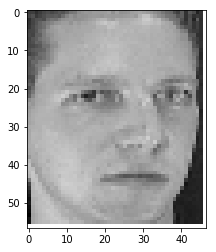

In [14]:
read_file=open('olivettifaces.pkl','rb')    
faces=pickle.load(read_file)  
read_file.close()   
img1=faces[1].reshape(57,47)  
pylab.imshow(img1)  
pylab.gray()  
pylab.show()  

In [15]:
print(faces.shape)

(400, 2679)


读取olivettifaces.pkl文件，分为训练集（40×8个样本），验证集（40×1个样本），测试集（40×1个样本）

In [15]:
read_file=open('olivettifaces.pkl','rb')    
faces=pickle.load(read_file)    
label=pickle.load(read_file)    
read_file.close()

In [17]:
train_data=np.empty((320,2679))  
train_label=np.empty(320)  
valid_data=np.empty((40,2679))  
valid_label=np.empty(40)  
test_data=np.empty((40,2679))  
test_label=np.empty(40)

In [18]:
for i in range(40):
    train_data[i*8:i*8+8]=faces[i*10:i*10+8]
    train_label[i*8:i*8+8]=label[i*10:i*10+8]
    valid_data[i]=faces[i*10+8]
    valid_label[i]=label[i*10+8]
    test_data[i]=faces[i*10+9]
    test_label[i]=label[i*10+9]

In [19]:
print(train_data.shape)

(320, 2679)


In [32]:
import tensorflow as tf
EPOCHS = 60
BATCH_SIZE = 100

In [27]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 57x47x1. Output = 53x43x5.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 5), mean = mu, stddev = sigma)) # weight1, 初始化权重, 57-5+1=53
    # W1.shape: [filter_height, filter_width, in_channels, out_channels]
    # 具体含义是[卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]
    #
    # x：为需要做卷积的输入图像，它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这样的shape，
    # 具体含义是[训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]，
    # 注意这是一个4维的Tensor，要求类型为float32和float64其中之一
    #
    # strides：卷积时在图像每一维的步长，这是一个一维的向量，长度4
    #
    # padding：string类型的量，只能是"SAME","VALID"其中之一，这个值决定了不同的卷积方式
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') # 实现卷积
    b1 = tf.Variable(tf.zeros(5)) # bias1
    x = tf.nn.bias_add(x, b1) # How does it work? the shape doesn't change
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 53x43x5. Output = 26x21x5.
    # ksize: The size of the window for each dimension of the input tensor.
    # strides: The stride of the sliding window for each dimension of the input tensor.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 22x17x10.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 5, 10), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(10))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 22x17x10. Output = 11x8x10.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 11x8x10. Output = 880.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 880. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(880, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    print("x shape:",x.get_shape())
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 40.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 40), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(40)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

print('done')

done


In [28]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 57, 47, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 40)

print('done')

done


In [29]:
rate = 0.0009

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate) #adam optimizer
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 53, 43, 5)
x shape: (?, 84)


In [30]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0}) #keep_prob?
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [38]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_data)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = random.shuffle(train_data, train_label)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(valid_data, valid_label)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...



TypeError: 'numpy.ndarray' object is not callable